In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%sh
sudo apt install -y fonts-cmu texlive-latex-extra cm-super dvipng
mkdir final-figures

In [64]:
import itertools
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tqdm
import typing

import theoretical_models

_ = matplotlib.rc("text", usetex=True)
_ = matplotlib.rc("font", family="serif", serif="CMU Serif")

In [280]:
def filter_dataframe(
    df: pd.DataFrame, 
    **kwargs,
) -> pd.DataFrame:
    """Filter the dataframe according to the keyword arguments"""
    filtered_df = df
    for key, value in kwargs.items():
        if not isinstance(value, typing.Union[list, tuple]):
            value = [value]
        filtered_df = filtered_df[filtered_df[key].isin(value)]
    return filtered_df


def render_subplot(
    ax: plt.axes,
    df: pd.DataFrame,
    x_axis: str,
    y_axis: str,
    lines: typing.Union[str, list[dict]] = [{}],
    lines_only: bool = False,
    markers_only: bool = False,
    markers: typing.Union[str, list[str]] = "o",
    linewidth: float = 2.0,
    linealpha: float = 1.0,
    linestyle: dict = {},
    markerfacecolor: str = "default",
    markeredgewidth: float = 2.5,
    markersize: float = 8.0,
    colors: typing.Union[str, list[str]] = None,
    legend: list[str] = None,
    logx: float = 0.0,
    logy: float = 0.0,
    xlim: tuple[float] = None,
    ylim: tuple[float] = None,
    xticks: list[float] = None,
    yticks: list[float] = None,
    xlabel: str = None,
    ylabel: str = None,
    label_fontsize: int = 13,
    remove_last: int = 0,
    **kwargs,
) -> None:
    """Plot a single subplot's data"""
    df = filter_dataframe(df, **kwargs).sort_values(x_axis)
    if isinstance(lines, str): lines = [{lines: sorted([*set(df[lines])])}]
    for line_id, line in enumerate(lines):
        legend_label = None if not legend else legend[line_id]
        color = colors[line_id] if isinstance(colors, list) else colors
        marker_color = color if markerfacecolor == "default" else markerfacecolor
        markeredgecolor = color if markerfacecolor in ["default", "none"] else markerfacecolor
        marker = markers if isinstance(markers, str) else markers[line_id]
        _df = filter_dataframe(df, **line)
        if not markers_only:
            ax.plot(
                _df[x_axis] if not remove_last else _df[x_axis][:-remove_last],
                _df[y_axis] if not remove_last else _df[y_axis][:-remove_last],
                color=color,
                **({"label": legend_label} if legend_label and lines_only else {}),
                linewidth=linewidth,
                alpha=linealpha,
                **linestyle,
            )
        if not lines_only:
            ax.plot(
                _df[x_axis] if not remove_last else _df[x_axis][:-remove_last],
                _df[y_axis] if not remove_last else _df[y_axis][:-remove_last],
                label=legend_label,
                marker=marker,
                linewidth=0,
                color=None,
                markerfacecolor="none" if lines_only else marker_color,
                markeredgecolor="none" if lines_only else markeredgecolor,
                markeredgewidth=0 if lines_only else markeredgewidth,
                markersize=markersize,
            )
    if logx: ax.set_xscale("log", base=logx)
    if logy: ax.set_yscale("log", base=logy)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xticks: ax.set_xticks(xticks)
    if yticks: ax.set_yticks(yticks)
    if xlabel != "": ax.set_xlabel(xlabel, fontsize=label_fontsize)
    if ylabel != "": ax.set_ylabel(ylabel, fontsize=label_fontsize)
    sns.despine()


def draw_legend(
    fig: plt.figure, 
    handles: list, 
    labels: list,
    height: float = 0.1,
    fontsize: float = 13,
    columns: int = None,
    columnspacing: float = 1.4,
    handletextpad: float = 1.4,
    tuple_pad: float = 1.6,
) -> None:
    """Draw a legend underneath the subplots"""
    return fig.legend(
        handles,
        labels,
        loc="lower center",
        frameon=False,
        fontsize=fontsize,
        ncol=(columns or len(labels)),
        columnspacing=columnspacing,
        handletextpad=handletextpad,
        bbox_to_anchor=(0.5, -height),
        handler_map={tuple: matplotlib.legend_handler.HandlerTuple(
            ndivide=None, 
            pad=tuple_pad,
        )},
    )



# Figure 1
### Bandwidth as $n$ scales

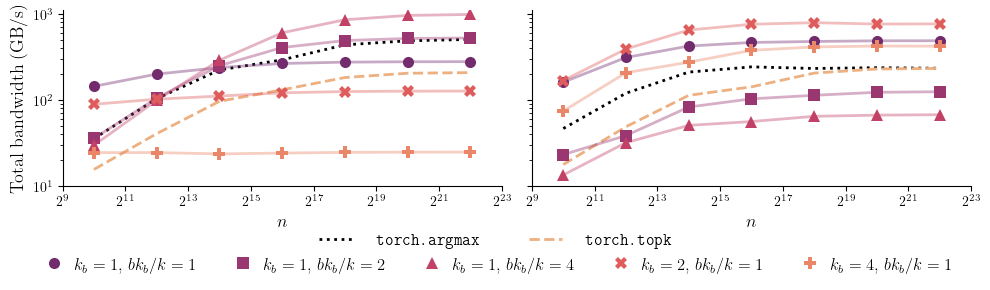

In [248]:
palette = sns.color_palette("flare_r", as_cmap=True)
    
def bandwidth(row):
    value = dict(float32=4, float16=2)[row["dtype"]]
    value *= row["n"] + row["k"]
    value *= row["batch_size"]
    value /= row["duration_mean"] / row["n_inner"]
    return value / 1e9

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5), sharey=True)

df = pd.read_json("../data/synth-data-merged-v2.jsonl", lines=True)
df.loc[:, "bandwidth"] = df.apply(bandwidth, axis=1)

methods = ["approx_topk.bucket_argmax.topk_torch", "approx_topk.torch_default.topk"]
legends = [r"$\texttt{torch.argmax}$", r"$\texttt{torch.topk}$"]
for ax, filtering in zip(axes, [{"k": 64}, {"n_over_k": 4}]):
    for line_id in range(2):
        render_subplot(
            ax=ax,
            df=df,
            x_axis="n",
            y_axis="bandwidth",
            lines=[{"method": methods[line_id]}],
            legend=[legends[line_id]],
            colors=["k", palette(0.9999)][line_id],
            lines_only=True,
            linestyle={"linestyle": "dashed" if line_id else "dotted"},
            logx=2,
            logy=10,
            batch_size=256,
            **filtering,
            **({} if line_id else {"compile": None}),
        )
    render_subplot(
        ax=ax,
        df=df,
        x_axis="n",
        y_axis="bandwidth",
        lines=[
            {"k_b": 1, "k_mult": 1},
            {"k_b": 1, "k_mult": 2},
            {"k_b": 1, "k_mult": 4},
            {"k_b": 2, "k_mult": 1},
            {"k_b": 4, "k_mult": 1},
        ],
        legend=[
            r"$k_b = 1$, $bk_b / k = 1$",
            r"$k_b = 1$, $bk_b / k = 2$",
            r"$k_b = 1$, $bk_b / k = 4$",
            r"$k_b = 2$, $bk_b / k = 1$",
            r"$k_b = 4$, $bk_b / k = 1$",
        ],
        markers=["o", "s", "^", "X", "P", "D", "v"],
        markeredgewidth=0,
        linealpha=0.4,
        linewidth=2,
        colors=[palette((i + 1) / 6) for i in range(5)],
        logx=2,
        logy=10,
        xlim=(2 ** 9, 2 ** 23),
        xticks=[2 ** i for i in range(9, 24, 2)],
        ylim=(10, 1100),
        xlabel=r"$n$",
        ylabel="Total bandwidth (GB/s)" if ax == axes[0] else "",
        batch_size=256,
        compile=None,
        k_b=[1, 2, 4],
        k_mult=[1, 2, 4],
        method="approx_topk.priority_queue.topk",
        **filtering,
    )

handles, labels = axes[0].get_legend_handles_labels()

legend_1 = draw_legend(
    fig, 
    handles[:2], 
    labels[:2], 
    height=0.075,
    columnspacing=3,
    fontsize=12,
)
legend_2 = draw_legend(
    fig, 
    handles[2:], 
    labels[2:], 
    height=0.175,
    columnspacing=1.8,
    fontsize=12,
    handletextpad=0.2,
)

plt.tight_layout()
fig.savefig(
    "final-figures/figure-01-bandwidth.pdf", 
    bbox_extra_artists=(legend_1, legend_2), 
    bbox_inches="tight",
)

# Figure 2
### SparQ empirical results

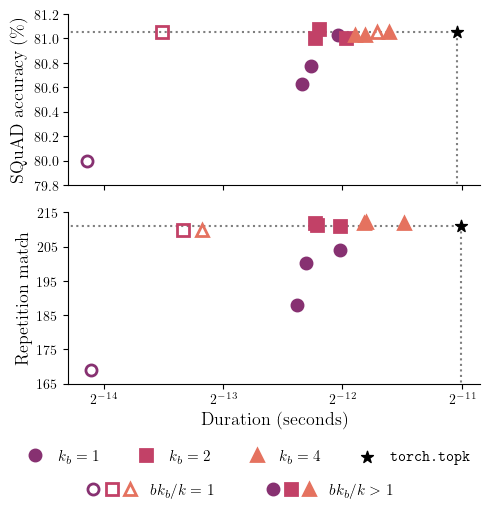

In [247]:
palette = sns.color_palette("flare_r", as_cmap=True)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 4.5), sharex=True)

df = pd.concat([
    pd.read_json("../data/sparq-data-merged.jsonl", lines=True),
    pd.read_json("../data/sparq-data-exact-merged.jsonl", lines=True),
])
df.loc[df["n"] == 1409, "score"] *= 100

for ax, task in zip(axes, ["squad", "repetition"]):
    n = {"squad": 1409, "repetition": 1659}[task]
    ylim = {"squad": (79.8, 81.2), "repetition": (165, 215)}[task]
    yticks = {
        "squad": [79.8, 80, 80.2, 80.4, 80.6, 80.8, 81, 81.2],
        "repetition": [165, 175, 185, 195, 205, 215],
    }[task]
    ylabel = {"squad": r"SQuAD accuracy ($\%$)", "repetition": "Repetition match"}[task]

    topk = filter_dataframe(df, n=n, exact_topk=True, compile=None)
    topk_score = topk.score.mean()
    topk_duration = topk.duration_mean.mean()
    plot_kwargs = {"color": "k", "linestyle": "dotted", "zorder": -2, "alpha": 0.5}
    scatter_kwargs = {"color": "k", "marker": "*", "s": 80, "label": r"$\texttt{torch.topk}$"}
    ax.plot([topk_duration, topk_duration], [0, topk_score], **plot_kwargs)
    ax.plot([0, topk_duration], [topk_score, topk_score], **plot_kwargs)
    ax.scatter(topk_duration, topk_score, **scatter_kwargs)

    for first_point in [True, False]:
        legend = None if first_point else [r"$k_b = 1$", r"$k_b = 2$", r"$k_b = 4$"]
        render_subplot(
            ax=ax,
            df=df[df.k_mult == 1 if first_point else df.k_mult > 1],
            x_axis="duration_mean",
            y_axis="score",
            lines=[{"k_b": 1}, {"k_b": 2}, {"k_b": 4}],
            legend=legend,
            markers_only=True,
            markers=["o", "s", "^"],
            markeredgewidth=2,
            markerfacecolor="none" if first_point else "default",
            colors=[palette((i + 1) / 4) for i in range(3)],
            logx=2,
            ylim=ylim,
            yticks=yticks,
            xlabel="Duration (seconds)" if task == "repetition" else "",
            ylabel=ylabel,
            n=n,
            method="approx_topk.priority_queue.topk",
            interleaved=True,
        )

handles, labels = axes[0].get_legend_handles_labels()

legend_1 = draw_legend(
    fig, 
    [*handles[1:], handles[0]], 
    [*labels[1:], labels[0]], 
    height=0.075,
    columnspacing=2,
    fontsize=11,
    handletextpad=0.5,
)

handles = [[], []]
for i, marker in enumerate("os^"):
    color = palette((i + 1) / 4)
    for handle_id, handle_kwargs in enumerate([{"markerfacecolor": "none"}, {"color": color}]):
        handles[handle_id] += [matplotlib.lines.Line2D(
            [], 
            [], 
            linewidth=0, 
            marker=marker,
            markeredgecolor=color, 
            markersize=8, 
            markeredgewidth=2,
            **handle_kwargs,
        )]
handles, labels = [*map(tuple, handles)], [rf"$bk_b/k = 1$", rf"$bk_b/k > 1$"]

legend_2 = draw_legend(
    fig, 
    handles, 
    labels, 
    height=0.15,
    columnspacing=4,
    fontsize=11,
    handletextpad=1.5,
)

plt.tight_layout()
fig.savefig(
    "final-figures/figure-02-sparq-tradeoff.pdf", 
    bbox_extra_artists=(legend_1, legend_2), 
    bbox_inches="tight",
)

# Figure 3
### Cost models for theoretical examples

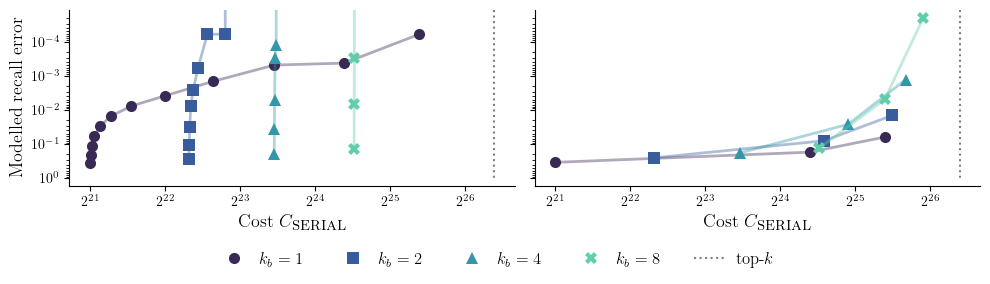

In [269]:
palette = sns.color_palette("mako", as_cmap=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5), sharey=True)

df = (pd.read_json("../data/theoretical_models.jsonl", lines=True)
      .pipe(lambda d: d.assign(error_model=1-d["recall_model"]))
      .pipe(lambda d: d.assign(error_simulation=1-d["recall_simulation"]))
      .pipe(lambda d: d.assign(n_over_k=d["n"] / d["k"]))
      .pipe(lambda d: d.assign(kb=d["k"] * d["b"]))
)

for ax, k in zip(axes, [256, 131072]):

    topk = filter_dataframe(df, n=1048576, algorithm="exact", k=k)
    ax.plot(
        [topk["cost_serial"].mean(), topk["cost_serial"].mean()], 
        [0, 1],
        color="k",
        linestyle="dotted",
        zorder=-2,
        alpha=0.5,
        label=r"top-$k$"
    )

    render_subplot(
        ax=ax,
        df=df,
        x_axis="cost_serial",
        y_axis="error_simulation",
        lines=[{"k_b": 2 ** i} for i in range(4)],
        legend=[fr"$k_b = {2 ** i}$" for i in range(4)],
        markers=["o", "s", "^", "X"],
        markeredgewidth=0,
        colors=[palette((i + 1) / 5) for i in range(4)],
        linealpha=0.4,
        logx=2,
        logy=10,
        xlabel=r"Cost $C_\textsc{serial}$",
        ylabel="Modelled recall error" if ax == axes[0] else "",
        remove_last=1,
        n=1048576,
        algorithm="approx",
        k=k,
    )

plt.gca().invert_yaxis()

handles, labels = axes[0].get_legend_handles_labels()
legend = draw_legend(
    fig, 
    [*handles[1:], handles[0]], 
    [*labels[1:], labels[0]], 
    height=0.15,
    columnspacing=2,
    fontsize=12,
    handletextpad=0.5,
)

plt.tight_layout()
fig.savefig(
    "final-figures/figure-03-theoretical-tradeoff.pdf", 
    bbox_extra_artists=(legend,), 
    bbox_inches="tight",
)

### ...and the full sweep for the appendix grid

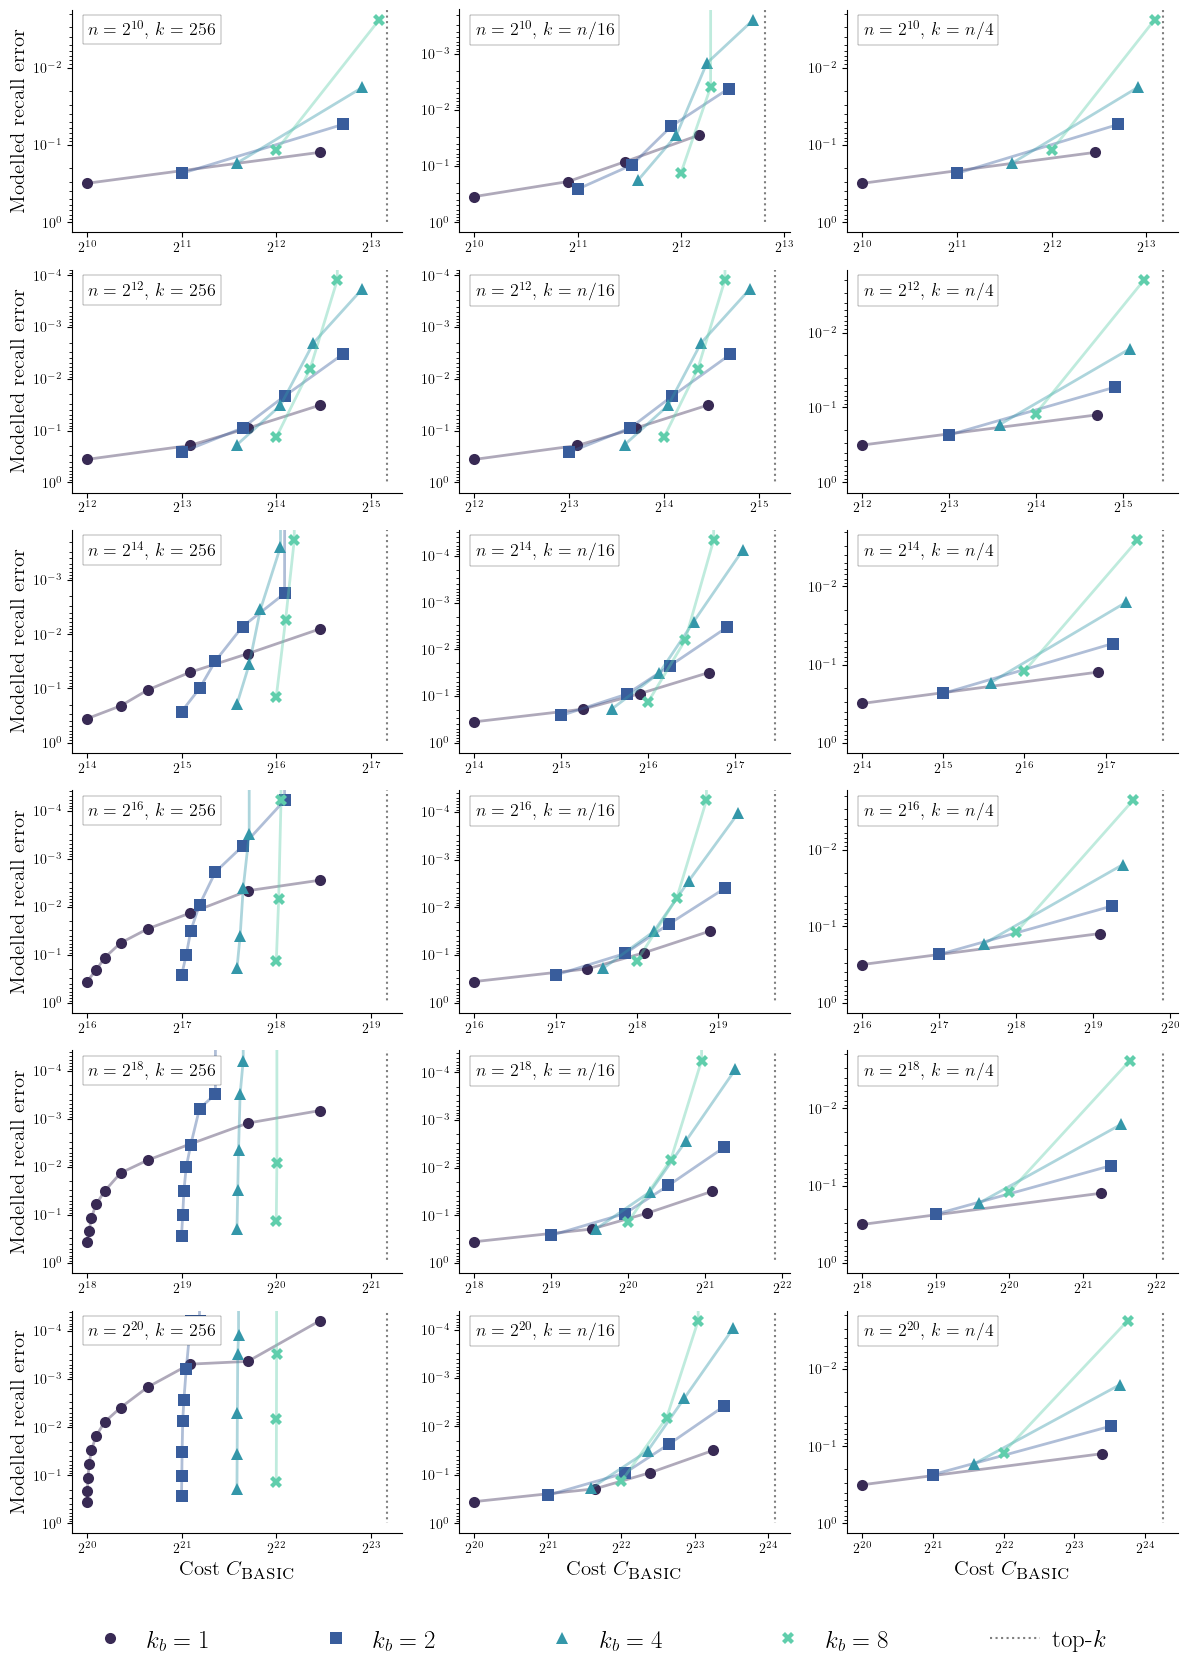

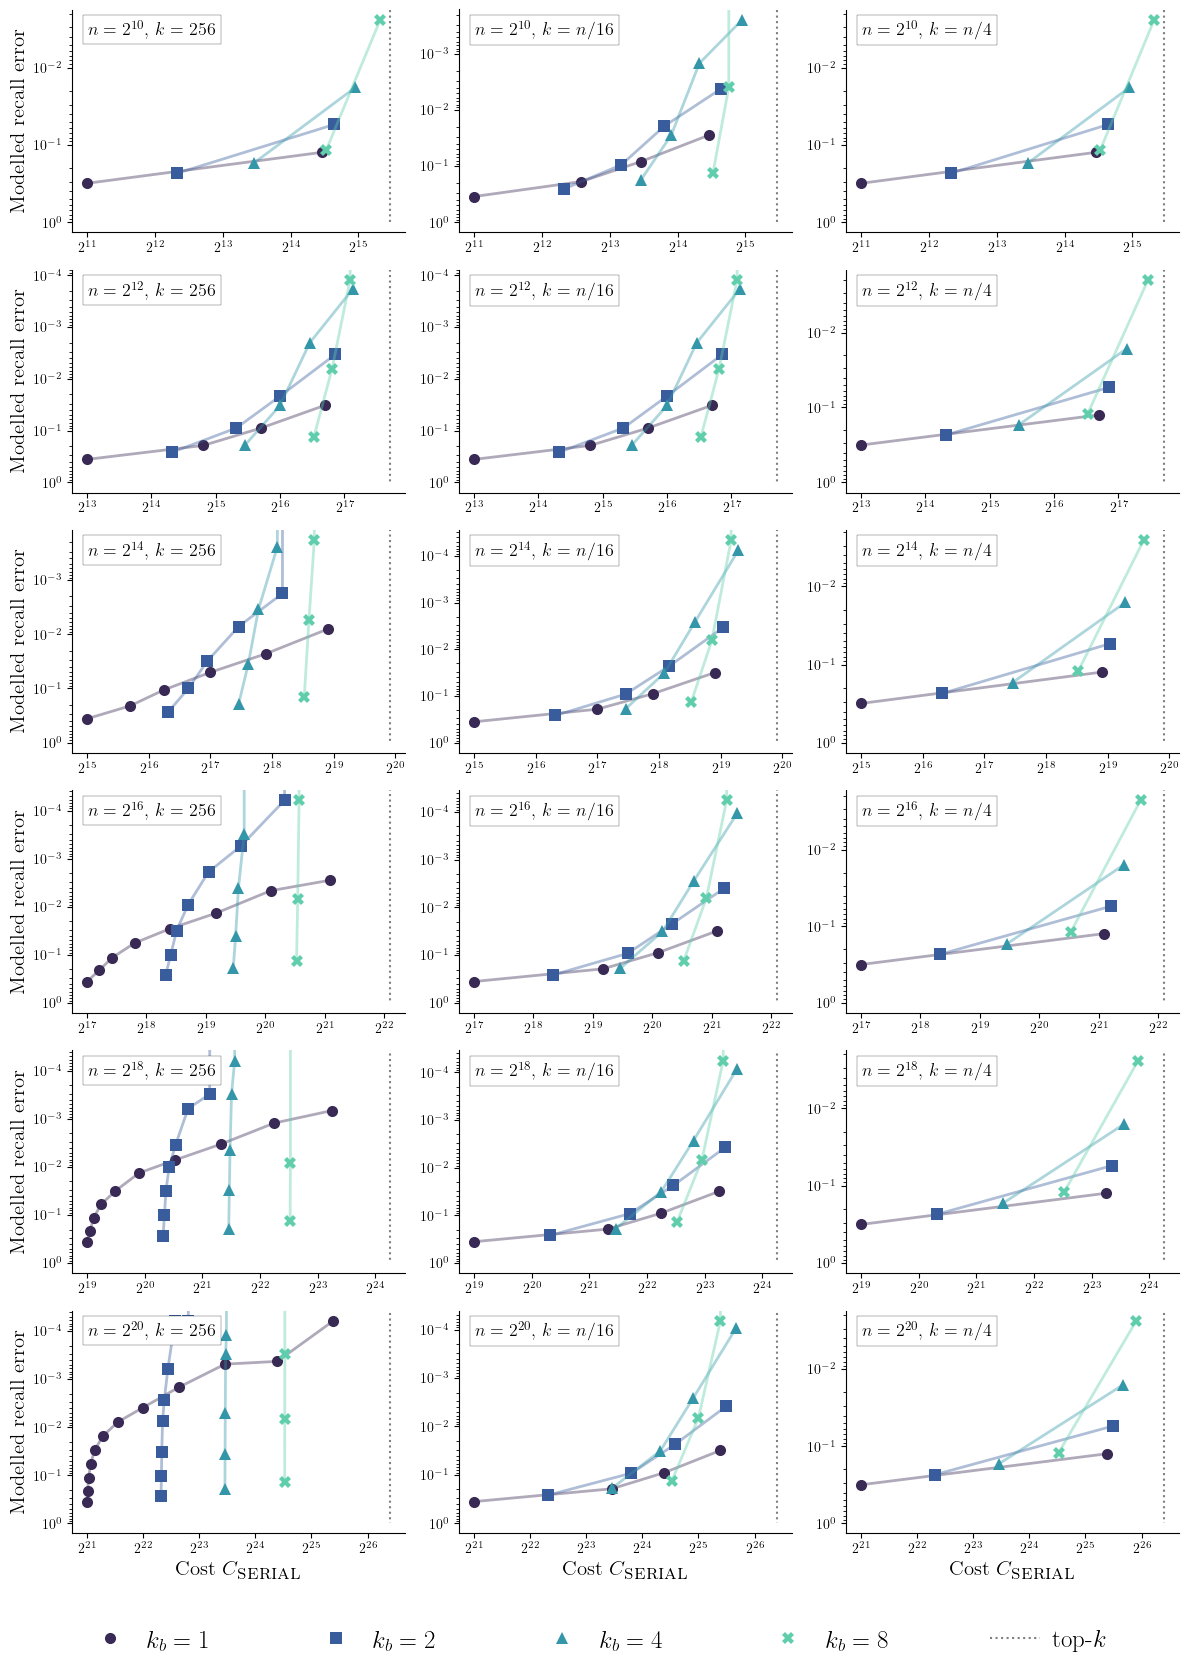

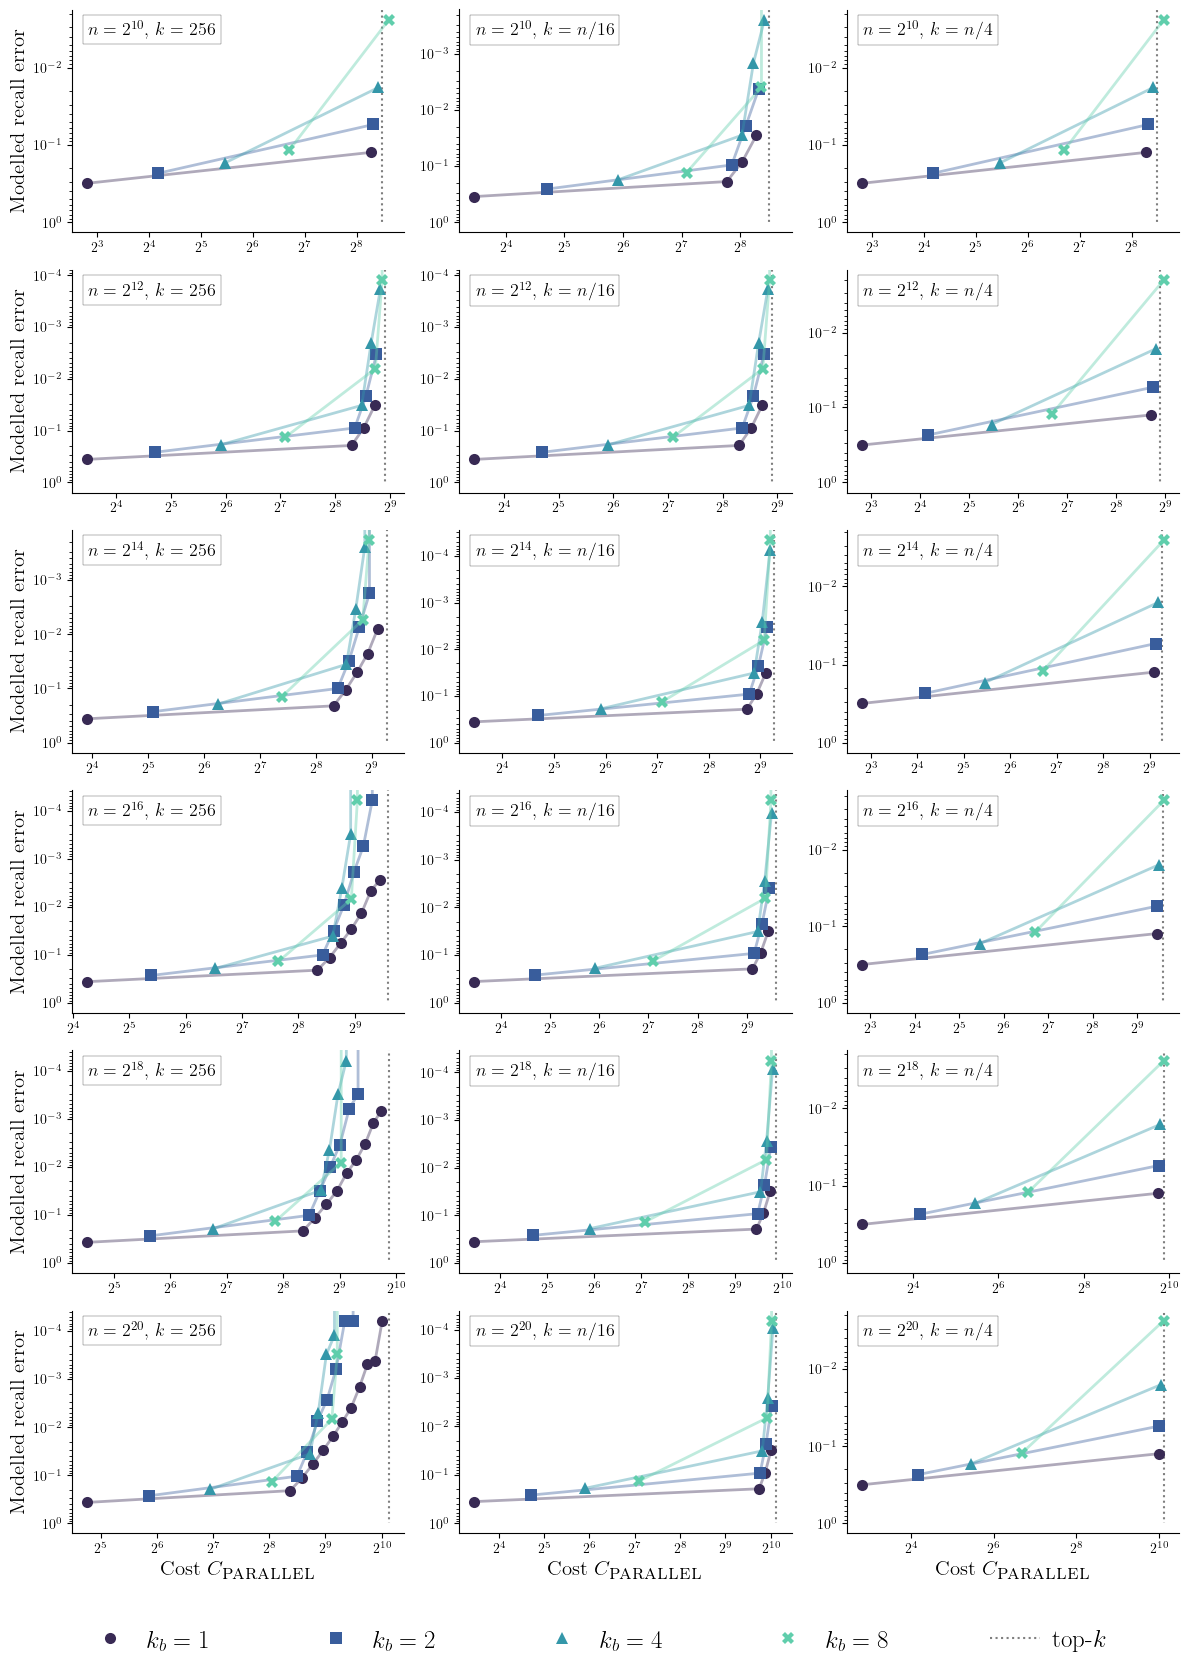

In [270]:
palette = sns.color_palette("mako", as_cmap=True)

df = (pd.read_json("../data/theoretical_models.jsonl", lines=True)
      .pipe(lambda d: d.assign(error_model=1-d["recall_model"]))
      .pipe(lambda d: d.assign(error_simulation=1-d["recall_simulation"]))
      .pipe(lambda d: d.assign(n_over_k=d["n"] / d["k"]))
      .pipe(lambda d: d.assign(kb=d["k"] * d["b"]))
)

conditions = [{"k": 256}, {"n_over_k": 16}, {"n_over_k": 4}]
column_names = [r"$k = 256$", r"$k = n / 16$", r"$k = n / 4$"]

for cost_model in ["basic", "serial", "parallel"]:
    fig, axes = plt.subplots(nrows=len(set(df.n)), ncols=3, figsize=(12, 16))

    for row_id, (axr, n) in enumerate(zip(axes, sorted([*set(df.n)]))):
        for ax, condition, column_name in zip(axr, conditions, column_names):
            
            topk = filter_dataframe(df, n=n, algorithm="exact", **condition)
            cost = topk[f"cost_{cost_model}"].mean()
            ax.plot(
                [cost, cost], 
                [0, 1],
                color="k",
                linestyle="dotted",
                zorder=-2,
                alpha=0.5,
                label=r"top-$k$"
            )

            xlabel = r"Cost $C_\textsc{" + cost_model + r"}$"
            ylabel = "Modelled recall error"
            render_subplot(
                ax=ax,
                df=df,
                x_axis=f"cost_{cost_model}",
                y_axis="error_simulation",
                lines=[{"k_b": 2 ** i} for i in range(4)],
                legend=[fr"$k_b = {2 ** i}$" for i in range(4)],
                markers=["o", "s", "^", "X"],
                markeredgewidth=0,
                colors=[palette((i + 1) / 5) for i in range(4)],
                linealpha=0.4,
                logx=2,
                logy=10,
                xlabel=xlabel if row_id == len(axes) - 1 else "",
                ylabel=ylabel if ax == axr[0] else "",
                label_fontsize=15,
                remove_last=1,
                n=n,
                algorithm="approx",
                **condition,
            )
            ax.text(
                0.05, 
                0.95, 
                f"$n=2^{{{math.log2(n):.0f}}}$, {column_name}", 
                va="top", 
                ha="left", 
                transform=ax.transAxes, 
                fontsize=13,
            ).set_bbox({"facecolor": "w", "linewidth": 0.2})
            ax.invert_yaxis()

    handles, labels = axes[0][0].get_legend_handles_labels()
    legend = draw_legend(
        fig, 
        [*handles[1:], handles[0]], 
        [*labels[1:], labels[0]], 
        height=0.05,
        columnspacing=4,
        fontsize=18,
        handletextpad=0.5,
    )

    plt.tight_layout()

    fig.savefig(
        f"final-figures/appendix-tradeoff-grid-cost-{cost_model}.pdf", 
        bbox_extra_artists=(legend,), 
        bbox_inches="tight",
    )

# Figure 4
### Downstream results for LLM vocabulary and KGC link prediction

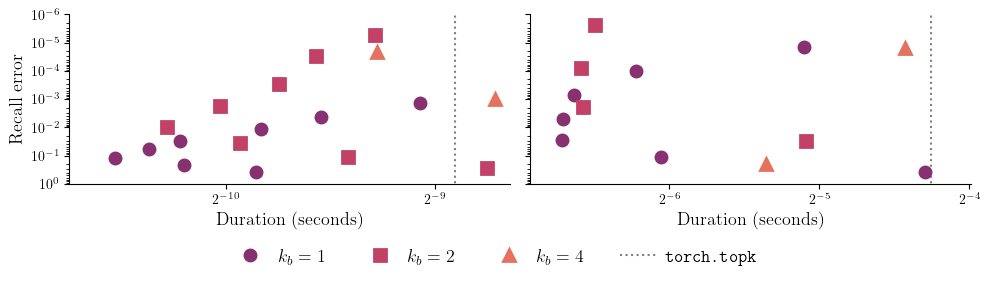

In [273]:
palette = sns.color_palette("flare_r", as_cmap=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5), sharey=True)

for ax, task in zip(axes, ["vocab", "graph"]):

    k, m, file = {
        "vocab": (256, 64, "../data/vocab-data-merged-compressed.jsonl"),
        "graph": (100, 128, "../data/graph-data-merged.jsonl"),
    }[task]
    df = pd.read_json(file, lines=True)

    topk_df = pd.read_json(f"../data/{task}-data-exact-merged.jsonl", lines=True)
    topk = filter_dataframe(topk_df, k=k, batch_size=m)
    ax.plot(
        [topk.duration_mean.mean(), topk.duration_mean.mean()], 
        [0, 1], 
        color="k",
        linestyle="dotted",
        zorder=-2,
        alpha=0.5,
        label=r"$\texttt{torch.topk}$",
    )

    render_subplot(
        ax=ax,
        df=df,
        x_axis="duration_mean",
        y_axis="error",
        lines=[{"k_b": 1}, {"k_b": 2}, {"k_b": 4}],
        legend=[r"$k_b = 1$", r"$k_b = 2$", r"$k_b = 4$"],
        markers_only=True,
        markers=["o", "s", "^"],
        markeredgewidth=2,
        colors=[palette((i + 1) / 4) for i in range(3)],
        logx=2,
        logy=10,
        xlabel="Duration (seconds)",
        ylabel="Recall error" if task == "vocab" else "",
        k=k,
        batch_size=m,
    )
    ax.set_xlim(right=1.2 * topk.duration_mean.mean())
    ax.set_ylim(top=1, bottom=1e-6)
    
plt.gca().invert_yaxis()


handles, labels = axes[0].get_legend_handles_labels()

legend = draw_legend(
    fig, 
    [*handles[1:], handles[0]], 
    [*labels[1:], labels[0]], 
    height=0.15,
    columnspacing=2,
    fontsize=13,
    handletextpad=0.5,
)

plt.tight_layout()
fig.savefig(
    "final-figures/figure-04-vocab-and-kgc-tradeoff.pdf", 
    bbox_extra_artists=(legend,), 
    bbox_inches="tight",
)

# Appendix
### Correlation factor scaling

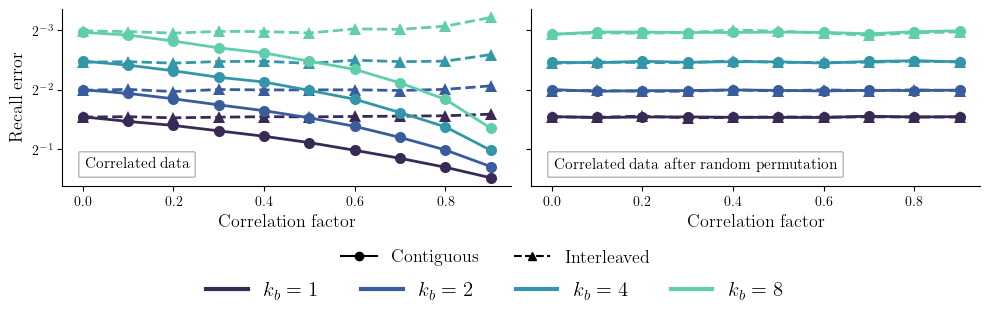

In [299]:
palette = sns.color_palette("mako", as_cmap=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5), sharey=True)

df = pd.read_json("../data/correlation/results.jsonl", lines=True)
df.loc[:, "error"] = df.apply(lambda r: 1 - r["recall_mean"], axis=1)

for ax, shuffle in zip(axes, [False, True]):
    for interleaved in [True, False]:
        marker = {True: "^", False: "o"}[interleaved]

        render_subplot(
            ax=ax,
            df=df,
            x_axis="corr_factor",
            y_axis="error",
            lines=[{"k_per_bucket": 2 ** i} for i in range(4)],
            legend=[fr"$k_b = {i}$" for i in range(4)],
            **({"linestyle": {"linestyle": "dashed"}} if interleaved else {}),
            markers=marker,
            markeredgewidth=0,
            colors=[palette((i + 1) / 5) for i in range(4)],
            logy=2,
            xlabel="Correlation factor",
            ylabel="Recall error" if not shuffle else "",
            interleaved=interleaved,
            shuffle=shuffle,
        )

        ax.text(
            0.05, 
            0.16, 
            "Correlated data" if not shuffle else "Correlated data after random permutation", 
            va="top", 
            ha="left", 
            transform=ax.transAxes, 
            fontsize=11,
        ).set_bbox({"facecolor": "w", "linewidth": 0.2})

plt.gca().invert_yaxis()

handles_1, handles_2, labels_1, labels_2 = [], [], [], []
handles_1.append(matplotlib.lines.Line2D([], [], color="k", marker="o"))
handles_1.append(matplotlib.lines.Line2D([], [], color="k", linestyle="dashed", marker="^"))
labels_1.append("Contiguous")
labels_1.append("Interleaved")
for i, k in enumerate([1, 2, 4, 8]):
    handles_2.append(matplotlib.lines.Line2D([], [], color=palette((i + 1) / 5), linewidth=3))
    labels_2.append(f"$k_b={k}$")

legend_1 = draw_legend(
    fig, 
    handles_1, 
    labels_1,
    height=0.15,
    columnspacing=2,
    fontsize=13,
    handletextpad=0.8,
)
legend_2 = draw_legend(
    fig, 
    handles_2, 
    labels_2,
    height=0.3,
    columnspacing=2,
    fontsize=15,
    handletextpad=0.8,
)

plt.tight_layout()
fig.savefig(
    "final-figures/appendix-theoretical-correlation-factor.pdf", 
    bbox_extra_artists=(legend_1, legend_2), 
    bbox_inches="tight",
)

### Comparing interleaved vs contiguous bucketing with SparQ Attention

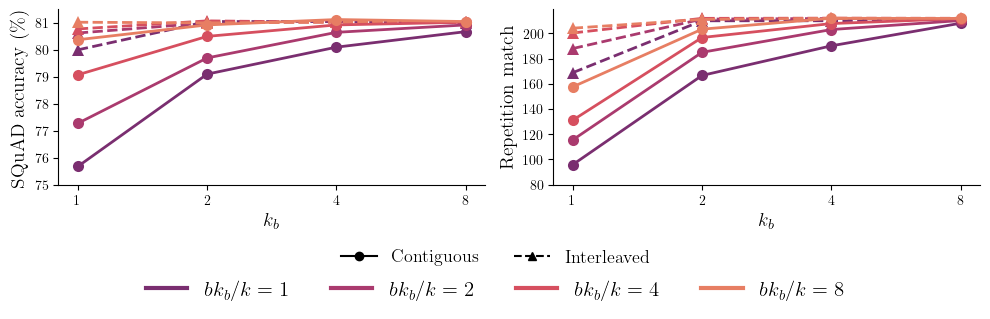

In [321]:
palette = sns.color_palette("flare_r", as_cmap=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))

df = pd.concat([
    filter_dataframe(
        pd.read_json("../data/sparq_v1.jsonl", lines=True),
        task_name="repetition",
        topk_k_per_bucket=[1, 2, 4, 8],
    ),
    filter_dataframe(
        pd.read_json("../data/sparq_v2.jsonl", lines=True),
        task_name="squad",
        topk_k_per_bucket=[1, 2, 4, 8],
    ),
])
df["topk_interleaved"] = df["topk_interleaved"].astype(bool)
df.loc[df["task_name"] == "squad", "score"] *= 100

for ax, task in zip(axes, ["squad", "repetition"]):
    ylabel = r"SQuAD accuracy ($\%$)" if task == "squad" else "Repetition match"
    for interleaved in [True, False]:
        marker = {True: "^", False: "o"}[interleaved]

        render_subplot(
            ax=ax,
            df=df,
            x_axis="topk_k_per_bucket",
            y_axis="score",
            lines=[{"topk_k_mult": 2 ** i} for i in range(4)],
            legend=[fr"$bk_b/k = {2 ** i}$" for i in range(4)],
            **({"linestyle": {"linestyle": "dashed"}} if interleaved else {}),
            markers=marker,
            markeredgewidth=0,
            colors=[palette((i + 1) / 5) for i in range(4)],
            logx=2,
            xlabel=r"$k_b$",
            ylabel=ylabel,
            label_fontsize=14,
            topk_interleaved=interleaved,
            task_name=task,
        )
        ax.set_xticks([1, 2, 4, 8], [1, 2, 4, 8])
        if task == "squad":
            ax.set_yticks(range(75, 83))
            ax.set_ylim([75, 81.5])
        else:
            ax.set_yticks(range(80, 270, 20))
            ax.set_ylim([80, 219])

handles_1, handles_2, labels_1, labels_2 = [], [], [], []
handles_1.append(matplotlib.lines.Line2D([], [], color="k", marker="o"))
handles_1.append(matplotlib.lines.Line2D([], [], color="k", linestyle="dashed", marker="^"))
labels_1.append("Contiguous")
labels_1.append("Interleaved")
for i, k in enumerate([1, 2, 4, 8]):
    handles_2.append(matplotlib.lines.Line2D([], [], color=palette((i + 1) / 5), linewidth=3))
    labels_2.append(f"$bk_b/k = {k}$")

legend_1 = draw_legend(
    fig, 
    handles_1, 
    labels_1,
    height=0.15,
    columnspacing=2,
    fontsize=13,
    handletextpad=0.8,
)
legend_2 = draw_legend(
    fig, 
    handles_2, 
    labels_2,
    height=0.3,
    columnspacing=2,
    fontsize=15,
    handletextpad=0.8,
)

plt.tight_layout()
fig.savefig(
    f"final-figures/appendix-correlation-sparq-results.pdf", 
    bbox_extra_artists=(legend_1,legend_2), 
    bbox_inches="tight",
)